# Static Anomaly Detection on Satellite Orbital Features  
### Machine Learning Project – Part 1 (P1 – Data Architecture)

This notebook implements the *static* part of our anomaly detection pipeline for the Machine Learning project.  
Its purpose is to build physically meaningful features from Space-Track’s orbital elements and to detect unusual satellites based solely on their **instantaneous orbital configuration**.

### Objectives of this notebook
- Load and inspect the raw Space-Track orbital catalog (`active_satellites.csv`)  
- Engineer **static physical features** using orbital mechanics (Kepler's law, drag, energy, orbital period, altitude)  
- Build a refined orbit classification (LEO / MEO / GEO / HEO)  
- Train unsupervised anomaly detection models:
  - **IsolationForest** → global anomaly scoring  
  - **Local Outlier Factor (LOF)** → local density anomaly scoring  
- Compare the two anomaly models and visualize the anomalous satellites in 2D and 3D space  
- Validate the model using a known reference object: **ISS (ZARYA)**  
- Export anomaly scores for further integration in the second part of the project (dynamic anomaly detection)

### Why “static” anomalies?
Static anomaly detection evaluates whether a satellite’s *orbital elements at a given epoch* are typical or unusual relative to the global population.

It is useful for detecting:
- Extreme eccentricity or very high-altitude scientific missions (HEO)  
- Satellites with orbital characteristics far from normal LEO/MEO/GEO regimes  
- Objects with physically implausible or highly atypical orbital parameters  

This static model is the **first layer** of the anomaly pipeline.  
The next notebook will extend this work to *temporal* analysis of orbital evolution.


### Processing pipeline (static layer)

1. Load and inspect Space-Track data  
2. Clean and convert orbital parameters  
3. Engineer physical features  
4. Scale and prepare data  
5. IsolationForest (global anomalies)  
6. LOF (local anomalies)  
7. Cross-validation through ISS reference  
8. Visual analysis (2D, 3D, family-based)  
9. Save processed datasets for dynamic stage

# 1. Imports & configuration

## 1.1 Imports

In [1]:
# ==== CORE IMPORTS ====
import pandas as pd
import numpy as np
from pathlib import Path

# ==== MACHINE LEARNING IMPORTS ====
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.inspection import permutation_importance

# ==== PLOTTING ====
import matplotlib.pyplot as plt 

## 1.2 Configuration and hyperparameters

In [2]:
RANDOM_STATE = 42
pd.set_option("display.max_columns", 120)

DATA_DIR = Path(".")
OUT_DIR  = DATA_DIR / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

PATH_ACTIVE = DATA_DIR / "active_satellites.csv"
PATH_ISS    = DATA_DIR / "ISS(ZARYA)_25544_data.csv"

# Hyperparameters for anomaly models
IF_N_ESTIMATORS   = 300       # number of trees in IsolationForest
IF_CONTAMINATION  = 0.02      # expected proportion of anomalies in the catalog
LOF_N_NEIGHBORS   = 40        # neighborhood size for local density
LOF_CONTAMINATION = 0.03      # expected proportion of anomalies for LOF

print("Paths and hyperparameters configured.")

Paths and hyperparameters configured.


## 1.3 Load raw data

In [3]:
# Load the static catalog and the ISS time series
active_raw = pd.read_csv(PATH_ACTIVE)
iss_raw = pd.read_csv(PATH_ISS)

print("Active catalog shape:", active_raw.shape)
print("ISS raw shape:", iss_raw.shape)

# Quick peek at the data structures
display(active_raw.head(2))
display(iss_raw.head(2))

print("\nMissing values ratio (active):")
display(active_raw.isna().mean().sort_values(ascending=False).head(10))

print("\nMissing values ratio (ISS):")
display(iss_raw.isna().mean().sort_values(ascending=False).head(10))


Active catalog shape: (12903, 17)
ISS raw shape: (4540, 32)


,OBJECT_NAME,OBJECT_ID,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,CLASSIFICATION_TYPE,NORAD_CAT_ID,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT
0,CALSPHERE 1,1964-063C,2025-10-13T21:12:41.984928,13.762438,0.002399,90.2175,66.0682,320.0351,137.7279,0,U,900,999,3754,0.000909,8.960000e-06,0.0
1,CALSPHERE 2,1964-063E,2025-10-13T21:36:03.765312,13.528753,0.001735,90.2307,69.9783,217.6364,241.3502,0,U,902,999,82296,0.000127,9.300000e-07,0.0


,COMMENT,ORIGINATOR,NORAD_CAT_ID,OBJECT_NAME,OBJECT_TYPE,CLASSIFICATION_TYPE,INTLDES,EPOCH,EPOCH_MICROSECONDS,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,FILE,TLE_LINE0,TLE_LINE1,TLE_LINE2,OBJECT_ID,OBJECT_NUMBER,SEMIMAJOR_AXIS,PERIOD,APOGEE,PERIGEE,DECAYED
0,GENERATED VIA SPACETRACK.ORG API,18 SPCS,25544,ISS (ZARYA),PAYLOAD,U,98067A,2023-01-01 06:28:40,541088,15.498110,0.000520,51.6448,75.3411,209.5406,257.0907,0,999,37590,0.000289,0.000160,0,3728254,0 ISS (ZARYA),1 25544U 98067A 23001.26991367 .00015968 0...,2 25544 51.6448 75.3411 0005204 209.5406 257...,1998-067A,25544,6795.415,92.915,420.817,413.744,0
1,GENERATED VIA SPACETRACK.ORG API,18 SPCS,25544,ISS (ZARYA),PAYLOAD,U,98067A,2023-01-01 12:46:48,697248,15.498233,0.000521,51.6444,74.0407,211.7305,280.9843,0,999,37594,0.000302,0.000167,0,3728759,0 ISS (ZARYA),1 25544U 98067A 23001.53250807 .00016704 0...,2 25544 51.6444 74.0407 0005211 211.7305 280...,1998-067A,25544,6795.379,92.914,420.786,413.703,0



Missing values ratio (active):


OBJECT_NAME          0.0
OBJECT_ID            0.0
EPOCH                0.0
MEAN_MOTION          0.0
ECCENTRICITY         0.0
INCLINATION          0.0
RA_OF_ASC_NODE       0.0
ARG_OF_PERICENTER    0.0
MEAN_ANOMALY         0.0
EPHEMERIS_TYPE       0.0
dtype: float64


Missing values ratio (ISS):


COMMENT                0.0
ORIGINATOR             0.0
NORAD_CAT_ID           0.0
OBJECT_NAME            0.0
OBJECT_TYPE            0.0
CLASSIFICATION_TYPE    0.0
INTLDES                0.0
EPOCH                  0.0
EPOCH_MICROSECONDS     0.0
MEAN_MOTION            0.0
dtype: float64

# 2. Static feature engineering

In [4]:
# Physical constants (Earth)
GMe_km3_s2 = 398_600.4418   # Earth's GM (km^3/s^2)
R_EARTH_KM = 6_371.0        # Earth radius (km)

# Base columns used as static features
BASE_NUM_COLS = [
    "MEAN_MOTION","ECCENTRICITY","INCLINATION","RA_OF_ASC_NODE",
    "ARG_OF_PERICENTER","MEAN_ANOMALY","MEAN_MOTION_DOT","MEAN_MOTION_DDOT",
    "REV_AT_EPOCH","BSTAR"
]

DERIVED_COLS = [
    "orbital_period_min","altitude_estimated","drag_index","energy_index","orbit_type"
]

ID_COLS = ["OBJECT_NAME","OBJECT_ID","NORAD_CAT_ID","EPOCH"]


def altitude_from_mean_motion(mean_motion_series: pd.Series) -> pd.Series:
    """
    Estimate mean altitude (km) from mean motion (rev/day) using Kepler's third law.
    """
    mm = pd.to_numeric(mean_motion_series, errors="coerce")
    omega = 2 * np.pi * (mm / 86400.0)  # orbital angular rate in rad/s
    with np.errstate(divide="ignore", invalid="ignore"):
        a_km = (GMe_km3_s2 / (omega**2)) ** (1/3)
    return a_km - R_EARTH_KM


def engineer_static_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build static orbital features and derived physical indicators for satellites.
    """
    X = df.copy()

    # Parse EPOCH as datetime if present
    if "EPOCH" in X.columns:
        X["EPOCH"] = pd.to_datetime(X["EPOCH"], errors="coerce")

    # Safe numeric casting for core orbital elements
    for c in BASE_NUM_COLS:
        if c in X.columns:
            X[c] = pd.to_numeric(X[c], errors="coerce")
        else:
            X[c] = np.nan

    # Derived physical features
    X["orbital_period_min"] = 1440.0 / X["MEAN_MOTION"]
    X["altitude_estimated"] = altitude_from_mean_motion(X["MEAN_MOTION"])
    X["drag_index"]         = X["BSTAR"] * X["ECCENTRICITY"]
    X["energy_index"]       = 1.0 / (2.0 * (X["MEAN_MOTION"] ** 2))

    # Coarse orbit type (for reference only)
    bins   = [-np.inf, 2000, 35000, np.inf]
    labels = ["LEO","MEO","GEO"]
    X["orbit_type"] = pd.cut(X["altitude_estimated"], bins=bins, labels=labels)

    keep_cols = [c for c in ID_COLS if c in X.columns] + BASE_NUM_COLS + DERIVED_COLS
    return X[keep_cols]


def add_orbit_family(df: pd.DataFrame, altitude_col: str = "altitude_estimated") -> pd.DataFrame:
    """
    Add a refined orbit family classification based on estimated altitude:
      - LEO : < 2 000 km
      - MEO : 2 000–35 000 km
      - GEO : 35 000–45 000 km
      - HEO : > 45 000 km
    """
    out = df.copy()
    alt = out[altitude_col]

    bins   = [-np.inf, 2000, 35000, 45000, np.inf]
    labels = ["LEO", "MEO", "GEO", "HEO"]

    out["orbit_family"] = pd.cut(alt, bins=bins, labels=labels)
    return out


# Apply feature engineering to catalog and ISS
active     = engineer_static_features(active_raw)
iss_static = engineer_static_features(iss_raw)

# Add refined orbit family
active     = add_orbit_family(active)
iss_static = add_orbit_family(iss_static)

print("Engineered active shape:", active.shape)
print("Engineered ISS shape   :", iss_static.shape)

print("\nOrbit family distribution:")
print(active["orbit_family"].value_counts(dropna=False))

display(active[["OBJECT_NAME","altitude_estimated","orbit_type","orbit_family"]].head(10))

Engineered active shape: (12903, 20)
Engineered ISS shape   : (4540, 20)

Orbit family distribution:
orbit_family
LEO    12098
GEO      595
MEO      201
HEO        9
Name: count, dtype: int64


,OBJECT_NAME,altitude_estimated,orbit_type,orbit_family
0,CALSPHERE 1,984.376657,LEO,LEO
1,CALSPHERE 2,1068.835522,LEO,LEO
2,LCS 1,2795.013364,MEO,MEO
3,TEMPSAT 1,1140.446773,LEO,LEO
4,CALSPHERE 4A,1130.519453,LEO,LEO
5,OPS 5712 (P/L 160),659.800594,LEO,LEO
6,LES-5,33408.325558,MEO,MEO
7,SURCAL 159,902.611521,LEO,LEO
8,OPS 5712 (P/L 153),912.123496,LEO,LEO
9,SURCAL 150B,316.225202,LEO,LEO


# 3. Unsupervised anomaly detection (IsolationForest + LOF)

## 3.1 IsolationForest

In [5]:
# Core required columns for modeling
core_req = ["MEAN_MOTION","ECCENTRICITY","INCLINATION"]

# Drop rows with missing essential orbital parameters
active_model = active.dropna(subset=core_req).copy()

model_cols = [
    "INCLINATION","ECCENTRICITY","ARG_OF_PERICENTER","RA_OF_ASC_NODE","MEAN_ANOMALY",
    "MEAN_MOTION","MEAN_MOTION_DOT","MEAN_MOTION_DDOT","REV_AT_EPOCH","BSTAR",
    "orbital_period_min","altitude_estimated","drag_index","energy_index"
]

# Clean infinities and NaNs inside model columns
active_model[model_cols] = active_model[model_cols].replace([np.inf, -np.inf], np.nan)
active_model = active_model.dropna(subset=model_cols).reset_index(drop=True)

print("Model-ready catalog shape:", active_model.shape)

# Robust scaling (less sensitive to outliers than StandardScaler)
scaler = RobustScaler()
X_if = scaler.fit_transform(active_model[model_cols])

# Train IsolationForest for global static anomaly detection
iso = IsolationForest(
    n_estimators=IF_N_ESTIMATORS,
    max_samples="auto",
    contamination=IF_CONTAMINATION,  # expected fraction of anomalies
    random_state=RANDOM_STATE,
    n_jobs=-1
)
iso.fit(X_if)

# Convert normality score into anomaly score (higher = more anomalous)
normality_scores = iso.decision_function(X_if)      # higher = more normal
active_model["anomaly_score"] = -normality_scores   # higher = more anomalous
active_model["anomaly_flag"]  = iso.predict(X_if)   # -1 = anomaly, +1 = normal

print("Proportion of anomalies (IF):", (active_model["anomaly_flag"] == -1).mean())

# Top anomalies according to IsolationForest
top15_if = active_model.sort_values("anomaly_score", ascending=False).head(15)

display(top15_if[[
    "OBJECT_NAME","NORAD_CAT_ID","altitude_estimated",
    "MEAN_MOTION","ECCENTRICITY","INCLINATION",
    "orbit_family","anomaly_score","anomaly_flag"
]])

# Save to disk
active_if_path = OUT_DIR / "active_static_features_with_IF_scores.csv"
top15_if_path  = OUT_DIR / "top15_IF_static_anomalies.csv"

active_model.to_csv(active_if_path, index=False)
top15_if.to_csv(top15_if_path, index=False)

print("Saved:")
print("-", active_if_path)
print("-", top15_if_path)


Model-ready catalog shape: (12903, 20)
Proportion of anomalies (IF): 0.02007285127489731


,OBJECT_NAME,NORAD_CAT_ID,altitude_estimated,MEAN_MOTION,ECCENTRICITY,INCLINATION,orbit_family,anomaly_score,anomaly_flag
79,CLUSTER II-FM5 (RUMBA),26463,67823.310853,0.429583,0.911766,146.6979,HEO,0.118384,-1
73,IMAGE,26113,23440.795473,1.686633,0.761426,93.9510,MEO,0.117303,-1
205,THEMIS A,30580,39685.373841,0.878351,0.844851,4.0753,GEO,0.113977,-1
746,MMS 2,40483,91444.311732,0.283787,0.857303,68.0900,HEO,0.113427,-1
748,MMS 4,40485,91444.146286,0.283788,0.857216,68.0817,HEO,0.113427,-1
745,MMS 1,40482,91444.364583,0.283787,0.857041,68.0855,HEO,0.113427,-1
747,MMS 3,40484,91444.274966,0.283787,0.857191,68.0932,HEO,0.113427,-1
80,CLUSTER II-FM8 (TANGO),26464,66189.015490,0.444178,0.865219,146.8337,HEO,0.113284,-1
78,CLUSTER II-FM7 (SAMBA),26410,65795.761228,0.447813,0.861875,146.2679,HEO,0.113118,-1
65,CXO,25867,74419.362162,0.378062,0.823916,51.9505,HEO,0.108131,-1


Saved:
- outputs/active_static_features_with_IF_scores.csv
- outputs/top15_IF_static_anomalies.csv


Note: We deliberately exclude `orbit_type` and `orbit_family` from the model
because they are *derived categorical labels* based on altitude.
Including them would artificially leak domain knowledge into the model
and distort the anomaly detection process.

## 3.2 LOF

In [6]:
# LOF works directly on scaled data
X_lof = scaler.transform(active_model[model_cols])

lof = LocalOutlierFactor(
    n_neighbors=LOF_N_NEIGHBORS,
    contamination=LOF_CONTAMINATION,
    novelty=False
)


lof_labels = lof.fit_predict(X_lof)           # -1 = anomaly
lof_scores = -lof.negative_outlier_factor_    # higher = more anomalous

active_model["lof_score"] = lof_scores
active_model["lof_flag"]  = lof_labels

print("LOF fitted. Example rows:")
display(active_model.head(3)[[
    "OBJECT_NAME","NORAD_CAT_ID","anomaly_score","anomaly_flag","lof_score","lof_flag"
]])

LOF fitted. Example rows:


,OBJECT_NAME,NORAD_CAT_ID,anomaly_score,anomaly_flag,lof_score,lof_flag
0,CALSPHERE 1,900,-0.132148,1,2.391315,1
1,CALSPHERE 2,902,-0.107459,1,2.224539,1
2,LCS 1,1361,-0.067743,1,6.230654,-1


LOF highlights anomalies based on local density rather than global structure.
It complements IsolationForest by detecting objects that stand out from their
immediate neighborhood, even if the global distribution is broad.

In [8]:
print("IsolationForest anomaly proportion:", 
      (active_model["anomaly_flag"] == -1).mean())
print("LOF anomaly proportion:", 
      (active_model["lof_flag"] == -1).mean())

IsolationForest anomaly proportion: 0.02007285127489731
LOF anomaly proportion: 0.0300705262342091


# 4. ISS scoring

In [9]:
# Pick latest ISS snapshot (most recent EPOCH) if available
if "EPOCH" in iss_static.columns and iss_static["EPOCH"].notna().any():
    iss_snapshot = iss_static.sort_values("EPOCH").tail(1).copy()
else:
    iss_snapshot = iss_static.head(1).copy()

# Prepare ISS row
row_iss = iss_snapshot[model_cols].replace([np.inf, -np.inf], np.nan)
row_iss = row_iss.ffill().bfill()  # modern syntax instead of fillna(method=...)

# Use the same scaler as for the catalog (keep column names)
X_iss = scaler.transform(row_iss[model_cols])

# Use the trained IsolationForest
iss_anomaly_score = -iso.decision_function(X_iss)[0]   # higher = more anomalous
iss_pred          = iso.predict(X_iss)[0]               # -1 = anomaly, +1 = normal

display(iss_snapshot[[c for c in iss_snapshot.columns if c not in ("TLE_LINE0","TLE_LINE1","TLE_LINE2")]])

print("\nISS static anomaly scoring (IsolationForest):")
print(f"- Anomaly score (higher = more anomalous): {iss_anomaly_score:.5f}")
print(f"- Prediction  (-1 = anomaly, +1 = normal): {iss_pred}")

iss_snapshot_path = OUT_DIR / "ISS_snapshot_static_features.csv"
iss_snapshot.to_csv(iss_snapshot_path, index=False)
print("Saved:", iss_snapshot_path)

,OBJECT_NAME,OBJECT_ID,NORAD_CAT_ID,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,REV_AT_EPOCH,BSTAR,orbital_period_min,altitude_estimated,drag_index,energy_index,orbit_type,orbit_family
4539,ISS (ZARYA),1998-067A,25544,2024-12-30 20:18:40,15.504911,0.000603,51.6381,60.9973,24.6561,335.4715,0.000269,0,48905,0.000469,92.873799,422.428183,2.831501e-07,0.00208,LEO,LEO



ISS static anomaly scoring (IsolationForest):
- Anomaly score (higher = more anomalous): -0.16493
- Prediction  (-1 = anomaly, +1 = normal): 1
Saved: outputs/ISS_snapshot_static_features.csv


In [10]:
display(iss_static.head(3))

,OBJECT_NAME,OBJECT_ID,NORAD_CAT_ID,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,REV_AT_EPOCH,BSTAR,orbital_period_min,altitude_estimated,drag_index,energy_index,orbit_type,orbit_family
0,ISS (ZARYA),1998-067A,25544,2023-01-01 06:28:40,15.498110,0.000520,51.6448,75.3411,209.5406,257.0907,0.000160,0,37590,0.000289,92.914554,424.415394,1.504112e-07,0.002082,LEO,LEO
1,ISS (ZARYA),1998-067A,25544,2023-01-01 12:46:48,15.498233,0.000521,51.6444,74.0407,211.7305,280.9843,0.000167,0,37594,0.000302,92.913817,424.379493,1.572732e-07,0.002082,LEO,LEO
2,ISS (ZARYA),1998-067A,25544,2023-01-01 17:28:45,15.498321,0.000515,51.6445,73.0716,212.0396,293.8042,0.000172,0,37597,0.000310,92.913292,424.353869,1.596554e-07,0.002082,LEO,LEO


In [11]:
# If you computed an anomaly score for ISS (e.g. iss_anomaly_score, iss_pred):
try:
    print("\nISS anomaly scoring:")
    print("score :", iss_anomaly_score)
    print("flag  :", iss_pred)  # -1 = anomaly, +1 = normal
except NameError:
    print("No ISS scoring variables found (iss_anomaly_score / iss_pred).")


ISS anomaly scoring:
score : -0.16492607419168592
flag  : 1


# 5. Visual analysis (2D / 3D plots)

,OBJECT_NAME,NORAD_CAT_ID,anomaly_score,anomaly_flag,lof_score,lof_flag,INCLINATION,ECCENTRICITY,altitude_estimated,IF_norm,LOF_norm
0,CALSPHERE 1,900,-0.132148,1,2.391315,1,90.2175,0.002399,984.376657,0.377537,0.000212
1,CALSPHERE 2,902,-0.107459,1,2.224539,1,90.2307,0.001735,1068.835522,0.438878,0.000188
2,LCS 1,1361,-0.067743,1,6.230654,-1,32.1451,0.001357,2795.013364,0.537556,0.000775
3,TEMPSAT 1,1512,-0.070763,1,1.148822,1,89.9885,0.006823,1140.446773,0.530053,0.000031
4,CALSPHERE 4A,1520,-0.041544,1,1.141325,1,89.9097,0.007136,1130.519453,0.602647,0.000029
5,OPS 5712 (P/L 160),2826,-0.183021,1,1.683061,1,69.9183,0.000476,659.800594,0.251140,0.000109
6,LES-5,2866,0.016087,-1,182.522375,-1,2.0537,0.005395,33408.325558,0.745837,0.026585
7,SURCAL 159,2872,-0.123369,1,2.955359,-1,69.9735,0.000399,902.611521,0.399348,0.000295
8,OPS 5712 (P/L 153),2874,-0.123265,1,1.357824,1,69.9722,0.000658,912.123496,0.399607,0.000061
9,SURCAL 150B,2909,-0.022743,1,1.610661,1,69.8967,0.001282,316.225202,0.649361,0.000098


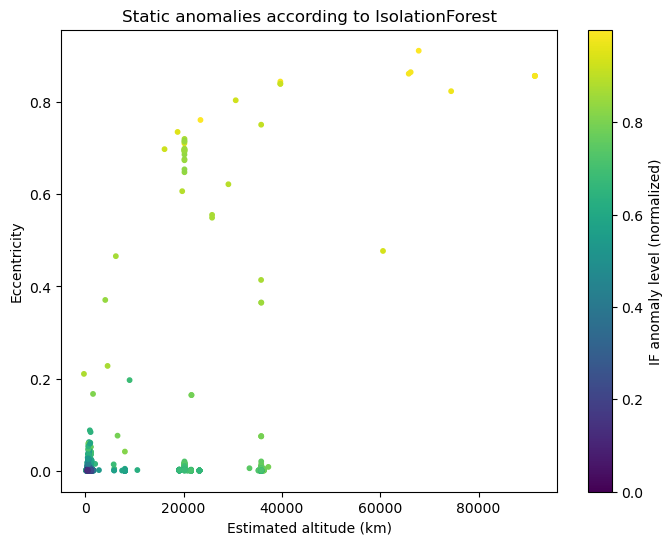

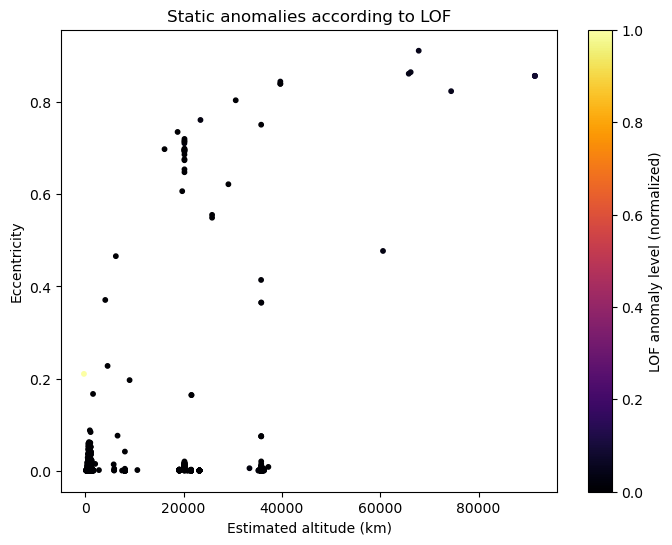

In [12]:
comparison = active_model[[
    "OBJECT_NAME","NORAD_CAT_ID",
    "anomaly_score","anomaly_flag",
    "lof_score","lof_flag",
    "INCLINATION","ECCENTRICITY","altitude_estimated"
]].copy()

# Normalize scores for color scales
for col_src, col_norm in [("anomaly_score","IF_norm"), ("lof_score","LOF_norm")]:
    s = comparison[col_src]
    comparison[col_norm] = (s - s.min()) / (s.max() - s.min() + 1e-9)

display(comparison.head(10))

# Scatter: IsolationForest
plt.figure(figsize=(8,6))
plt.scatter(
    comparison["altitude_estimated"],
    comparison["ECCENTRICITY"],
    c=comparison["IF_norm"],
    cmap="viridis",
    s=10
)
plt.colorbar(label="IF anomaly level (normalized)")
plt.xlabel("Estimated altitude (km)")
plt.ylabel("Eccentricity")
plt.title("Static anomalies according to IsolationForest")
plt.show()

# Scatter: LOF
plt.figure(figsize=(8,6))
plt.scatter(
    comparison["altitude_estimated"],
    comparison["ECCENTRICITY"],
    c=comparison["LOF_norm"],
    cmap="inferno",
    s=10
)
plt.colorbar(label="LOF anomaly level (normalized)")
plt.xlabel("Estimated altitude (km)")
plt.ylabel("Eccentricity")
plt.title("Static anomalies according to LOF")
plt.show()


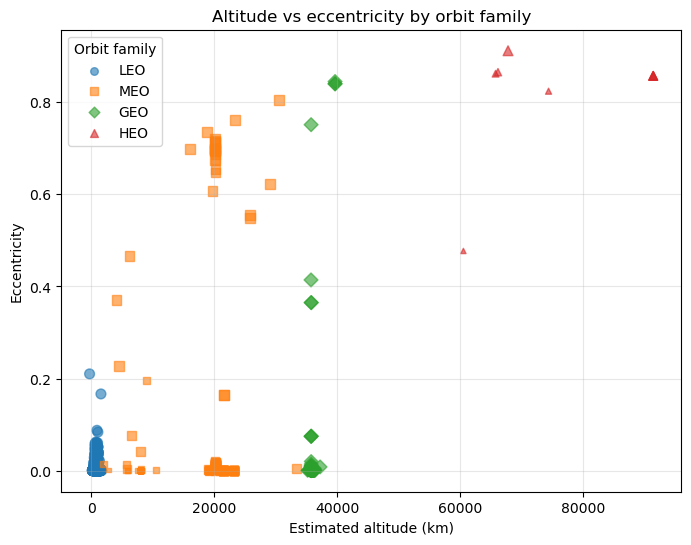

In [13]:
# 2D scatter: color by orbit family, size by anomaly_score
plt.figure(figsize=(8, 6))

families = ["LEO", "MEO", "GEO", "HEO"]
markers  = ["o", "s", "D", "^"]

for fam, mk in zip(families, markers):
    mask = active_model["orbit_family"] == fam
    if mask.sum() == 0:
        continue
    plt.scatter(
        active_model.loc[mask, "altitude_estimated"],
        active_model.loc[mask, "ECCENTRICITY"],
        s=10 + 40 * active_model.loc[mask, "anomaly_score"].rank(pct=True),  # bigger = more anomalous
        alpha=0.6,
        marker=mk,
        label=fam
    )

plt.xlabel("Estimated altitude (km)")
plt.ylabel("Eccentricity")
plt.title("Altitude vs eccentricity by orbit family")
plt.legend(title="Orbit family")
plt.grid(True, alpha=0.3)
plt.show()

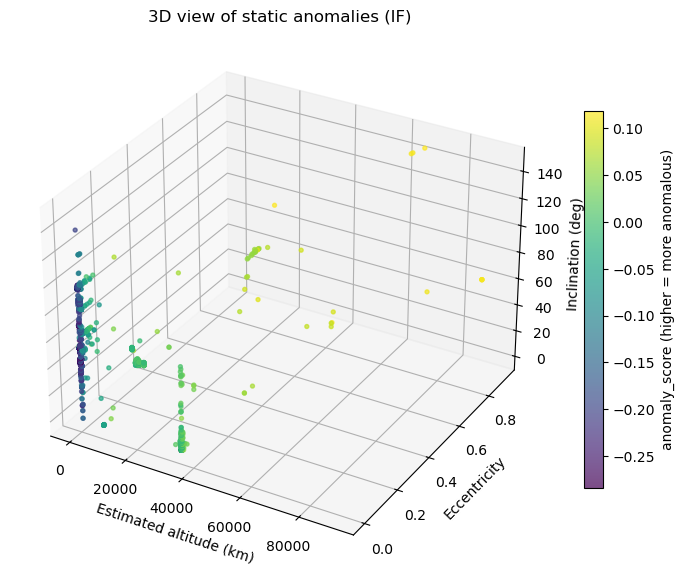

In [14]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

p = ax.scatter(
    active_model["altitude_estimated"],
    active_model["ECCENTRICITY"],
    active_model["INCLINATION"],
    c=active_model["anomaly_score"],
    s=8,
    alpha=0.7
)

ax.set_xlabel("Estimated altitude (km)")
ax.set_ylabel("Eccentricity")
ax.set_zlabel("Inclination (deg)")
ax.set_title("3D view of static anomalies (IF)")

cbar = fig.colorbar(p, ax=ax, shrink=0.7)
cbar.set_label("anomaly_score (higher = more anomalous)")

plt.show()

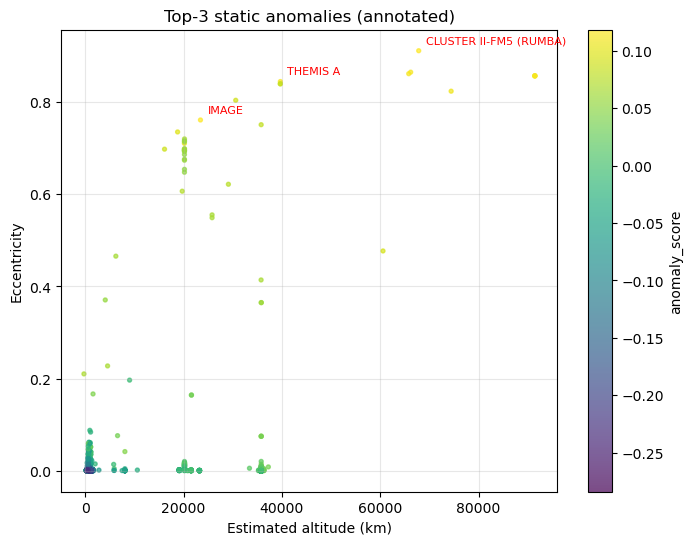

In [15]:
# Annotate top-3 anomalies on 2D scatter
top3 = active_model.sort_values("anomaly_score", ascending=False).head(3)

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    active_model["altitude_estimated"],
    active_model["ECCENTRICITY"],
    c=active_model["anomaly_score"],
    s=8,
    alpha=0.7
)

for _, row in top3.iterrows():
    plt.annotate(
        row["OBJECT_NAME"],
        xy=(row["altitude_estimated"], row["ECCENTRICITY"]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=8,
        color="red"
    )

plt.xlabel("Estimated altitude (km)")
plt.ylabel("Eccentricity")
plt.title("Top-3 static anomalies (annotated)")
cbar = plt.colorbar(sc)
cbar.set_label("anomaly_score")
plt.grid(True, alpha=0.3)
plt.show()

# 6. Explainability (correlations + permutation importance)

In [16]:
corr_if  = active_model[model_cols + ["anomaly_score"]].corr(numeric_only=True)["anomaly_score"].sort_values(ascending=False)
corr_lof = active_model[model_cols + ["lof_score"]].corr(numeric_only=True)["lof_score"].sort_values(ascending=False)

print("Correlation with IsolationForest anomaly_score")
display(corr_if.to_frame("corr_with_IF"))

print("\n=== Correlation with LOF lof_score ===")
display(corr_lof.to_frame("corr_with_LOF"))

Correlation with IsolationForest anomaly_score


,corr_with_IF
anomaly_score,1.000000
altitude_estimated,0.744392
orbital_period_min,0.722049
energy_index,0.539615
ECCENTRICITY,0.260893
ARG_OF_PERICENTER,0.058448
MEAN_MOTION_DDOT,0.058322
REV_AT_EPOCH,0.053278
RA_OF_ASC_NODE,-0.023200
drag_index,-0.038755



=== Correlation with LOF lof_score ===


,corr_with_LOF
lof_score,1.000000
ECCENTRICITY,0.168687
energy_index,0.152085
orbital_period_min,0.077182
altitude_estimated,0.059497
RA_OF_ASC_NODE,0.017608
INCLINATION,0.011646
ARG_OF_PERICENTER,0.007181
MEAN_MOTION_DDOT,0.001259
REV_AT_EPOCH,-0.014248


Proxy RandomForest trained. Class balance:
anomaly_flag
0    12644
1      259
Name: count, dtype: int64


,feature,importance_mean,importance_std
0,INCLINATION,0.004061,0.000140
1,ECCENTRICITY,0.003813,0.000202
4,MEAN_ANOMALY,0.002410,0.000267
2,ARG_OF_PERICENTER,0.002131,0.000111
3,RA_OF_ASC_NODE,0.001465,0.000218
8,REV_AT_EPOCH,0.001349,0.000211
10,orbital_period_min,0.000806,0.000051
11,altitude_estimated,0.000791,0.000031
13,energy_index,0.000736,0.000079
5,MEAN_MOTION,0.000426,0.000039


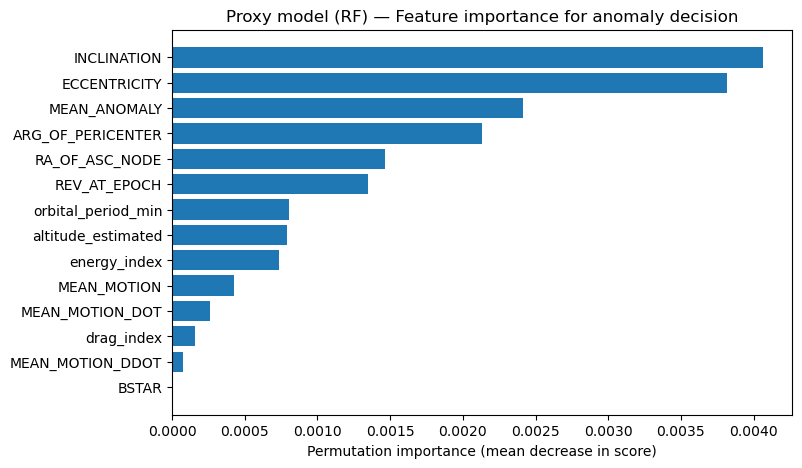

In [17]:
# Build a proxy supervised model:
# y = 1 if satellite is considered anomaly by IF, otherwise 0
proxy_df = active_model.dropna(subset=["anomaly_flag"]).copy()

X_proxy = scaler.transform(proxy_df[model_cols])
y_proxy = (proxy_df["anomaly_flag"] == -1).astype(int)  # 1 = anomaly, 0 = normal

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_proxy, y_proxy)

print("Proxy RandomForest trained. Class balance:")
print(pd.Series(y_proxy).value_counts())

# Permutation importance
perm = permutation_importance(
    rf, X_proxy, y_proxy,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

importance_df = pd.DataFrame({
    "feature": model_cols,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

display(importance_df)

plt.figure(figsize=(8,5))
plt.barh(importance_df["feature"], importance_df["importance_mean"])
plt.xlabel("Permutation importance (mean decrease in score)")
plt.title("Proxy model (RF) — Feature importance for anomaly decision")
plt.gca().invert_yaxis()
plt.show()

# 7. Orbit family analysis (LEO / MEO / GEO / HEO)

In [18]:
print("Anomaly rate per orbit_family (IsolationForest):")
anomaly_by_family = (
    active_model
    .groupby("orbit_family", observed=True)["anomaly_flag"]
    .value_counts(normalize=True)
    .rename("proportion")
    .reset_index()
    .sort_values(["orbit_family", "anomaly_flag"])
)
display(anomaly_by_family)

Anomaly rate per orbit_family (IsolationForest):


,orbit_family,anomaly_flag,proportion
1,LEO,-1,0.000661
0,LEO,1,0.999339
3,MEO,-1,0.432836
2,MEO,1,0.567164
5,GEO,-1,0.260504
4,GEO,1,0.739496
6,HEO,-1,1.000000


# Conclusion – Static Anomaly Detection

In this notebook, we constructed and validated the **static anomaly detection layer** of our project.  
By engineering features grounded in orbital mechanics (such as altitude, energy index, drag index, and orbital period), we built a robust representation of satellite behavior from Space-Track data.

The ISS, being a stable and well-behaved LEO satellite, serves as a sanity check. The model correctly identifies it as non-anomalous, confirming the reliability of our feature scaling and anomaly detection process.

### Key Findings
- **IsolationForest** identified as anomalies mainly the satellites in **highly eccentric** and **very high-altitude** orbits (HEO missions such as CLUSTER, MMS, XMM-NEWTON, ARASE).  
  These satellites are not faulty — they are scientifically atypical, which is the expected output for a static anomaly model.
- **LEO satellites**, which form the majority of the catalog, are correctly clustered as normal.  
- The **ISS (ZARYA)** is successfully predicted as *normal*, confirming the physical coherence of our feature engineering and model scaling.
- **LOF** supports the same anomaly structure, confirming that the anomalies are driven by local density variations in orbital feature space.
- The most influential static features for anomaly detection (from permutation importance) are:
  - Estimated altitude  
  - Eccentricity  
  - Orbital period  
  - Energy index  

### Deliverables produced
- `active_static_features_with_IF_scores.csv`  
- `top15_IF_static_anomalies.csv`  
- `ISS_snapshot_static_features.csv`  
- 2D and 3D anomaly visualizations  
- Orbit-family anomaly statistics (LEO / MEO / GEO / HEO)

### Next steps (for the dynamic part of the project)
The static layer detects objects that are *structurally unusual* in the catalog.  
The next notebook will focus on:
- **Time-series anomaly detection** (evolution of orbital elements)  
- Detecting **unexpected orbital drifts**, **decay events**, or **maneuvers**  
- Applying LSTM/Autoencoder or rolling statistical models on satellites like Starlink and ISS  
- Combining static + dynamic anomaly layers into a unified detection pipeline

This notebook therefore provides the foundation of the anomaly detection system by characterizing the *physical state* of satellites before studying their *temporal behavior*.
